# ML.py, MLpy, MLPy!
<p style="text-align: center;">MLpy came as a simple question <i>and</i> a project in pespective:
<br><b>"Can I build a discord bot that can tell two pictures apart?"</b></p>
<br>The goal of this Jupyter Notebook is two-fold with one overarching thread:

1. To build a web crawler that can crawl a statistically relevant number of images from [derpibooru](https://derpibooru.org), a linear image database powered by the community revolving around the 'My Little Pony' G4 show.
2. To build a machine learning model capable of telling the difference between 2 types of pictures--to be summarized in a function to implement in my existing Discord bot [BotJack](https://github.com/LMquentinLR/botjack_discord_bot).

### Why image detection for a Discord bot?
A Discord moderation team may want to identify images posted on their server for multiple purposes: classification, tagging, games, etc. 
<p style="text-align: center;">This notebook will focus on <b>compliance</b>.</p> 

* Servers often have anti-NSFW (i.e. not safe for watch) rules where explicit, grim, and otherwise unwanted content is banned or curtailed to specific server channels.
* Moderation being volunteer-driven on Discord, malicious users may capitalize on idle, asleep, or away-from-keyboard moderators to engage in rule-breaking activities. More commonly, users may simply post a NSFW picture in a SFW-only channel. 
* A bot able to distinguish NSFW content from SFW helps fill in the breaches that may affect any moderation effort. A bot, for instance, could automatically alert moderators when a specific content is posted and start a moderating process prior to any human intervention.

> <b>Automatic content moderation and compliance is a current industry effort in social media (e.g. Facebook)</b>, making this notebook a real world application.

In [1]:
import collections
import derpi_get #datacrawler available here: https://github.com/LMquentinLR/derpi_get
import datetime
import json
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.layers import GaussianNoise
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
from random import shuffle
import shutil
import time

Using TensorFlow backend.


### Building a web crawler
Derpibooru is a website dedicated to fan MLP art. It provides a REST API for rudimentary site functionality, It can be freely used by anyone wanting to produce tools for the site or other webapps that use Derpibooru-provided data.

<b>Derpibooru licensing rules</b>

"<i>Anyone can use it, users making abusively high numbers of requests may be asked to stop. Your application MUST properly cache, respect server-side cache expiry times. Your client MUST gracefully back off if requests fail (eg non-200 HTTP code), preferably exponentially or fatally.</i>"

A single image can be accessed through the following links:
1. <b>Embedded</b>: [../2072316](https://derpibooru.org/2072316)
2. <b>Default size</b>: [../img/view/2019/6/22/2072316.png](https://derpicdn.net/img/view/2019/6/22/2072316.png) 
3. <b>Small size</b>: [../img/view/2019/6/22/2072316_small.png](https://derpicdn.net/img/view/2019/6/22/2072316_small.png)
4. <b>Medium size</b>: [../img/view/2019/6/22/2072316_medium.png](https://derpicdn.net/img/view/2019/6/22/2072316_medium.png)
5. <b>Large size</b>: [../img/view/2019/6/22/2072316_large.png](https://derpicdn.net/img/view/2019/6/22/2072316_large.png)

The metadata of a single picture can be accessed through the following link:
* https://derpibooru.org/2072316.json

Each picture as the following list of attributes:
>id, created_at, updated_at, first_seen_at, score, comment_count, width, height, file_name, description, uploader, uploader_id, image, upvotes, downvotes, faves, tags, tag_ids, aspect_ratio, original_format, mime_type, sha512_hash, orig_sha512_hash, source_url, representations, is_rendered, is_optimized, interactions, spoilered

------------------

## Initializing object

In [2]:
obj = derpi_get.derpibooru_search()

## Crawling
1. Test #1 would retrieve all existing available picture metadata but will stop at the 10th requested page
2. Test #2 will retrieve all existing available picture metadata (can take up to 60h as at July 2019 if you crawl the full derpibooru database)

In [ ]:
#test #1
obj.change_search(instances = 10)
obj.crawl()

In [3]:
#test #2
obj.change_search(instances = "")
obj.crawl()

----|Entering Derpibooru Data Crawler code|----
You are requesting the derpibooru page starting with the id 2155311.
You are requesting the derpibooru page starting with the id 2155337.
You are requesting the derpibooru page starting with the id 2155362.
SPLIT: JSON file to be split as 1Mb max size reached.
FILE CREATED: 'derpibooru_metadata.json'
You are requesting the derpibooru page starting with the id 2155387.
You are requesting the derpibooru page starting with the id 2155413.
You are requesting the derpibooru page starting with the id 2155439.
You are requesting the derpibooru page starting with the id 2155465.
You are requesting the derpibooru page starting with the id 2155490.
You are requesting the derpibooru page starting with the id 2155515.
You are requesting the derpibooru page starting with the id 2155540.
You are requesting the derpibooru page starting with the id 2155565.
You are requesting the derpibooru page starting with the id 2155590.
You are requesting the derpib

From time to time, retrieved metadata (as a JSON) would be missing their tags value. The following method checks for existing missing tags and retrieve them from derpibooru.

In [4]:
obj.repair()

----|Repairing missing tags in stored JSON|----
----------------|Tags repaired|----------------


## Retrieving IDs based on tag selection

The derpi_get search function takes a list of strings. Each string which must match the following format:

> "+tag" <i>or</i> "-tag"

> <b>+</b> indicates keeping the ID during search, <b>-</b> indicates removing the ID

The [at_least_one] variable indicates:
1. if <b>TRUE</b>: <b>Only</b> the IDs, which tags <b>contain at least one</b> of the items listed in the variable [tags] with a "+" prefix, will be retrieved
2. if <b>FALSE</b>: <b>Only</b> the IDs, which tags <b>contain all</b> of the items listed in the variable [tags] with a "+" prefix, will be retrieved

In [ ]:
search_tags = ["+safe", "+rarijack"]
search_include = False
obj.change_search(tags = search_tags, at_least_one = search_include)

In [ ]:
id_list = obj.retrieve_ids()

print(len(id_list))
print(type(id_list))
print("\nFirst five items retrieved:")
print(id_list[:5])

### Retrieving pictures based on retrieved IDs

In [ ]:
nb_of_requests = len(id_list)
print(nb_of_requests)

In [ ]:
obj.request_imgs(search_tags, id_list)

## Data Exploration Using MatPlotlib

#### What do we want to plot?

> number of "safe" pictures posted across time that fit the tag "rarijack".

In [5]:
obj.change_search(tags = ["+rarijack"], at_least_one = False)
rarijack = obj.retrieve_ids()
obj.change_search(tags = ["+rarilight"], at_least_one = False)
rarilight = obj.retrieve_ids()
obj.change_search(tags = ["+flarity"], at_least_one = False)
flarity = obj.retrieve_ids()
obj.change_search(tags = ["+raridash"], at_least_one = False)
raridash = obj.retrieve_ids()
obj.change_search(tags = ["+raripie"], at_least_one = False)
raripie = obj.retrieve_ids()

----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------


### MatplotLib

In [6]:
ships = {"rarijack":rarijack,
        "rarilight":rarilight,
        "flarity":flarity,
        "raridash":raridash,
        "raripie":raripie}

In [7]:
def create_dataframe(name, data):
    """
    Creates the dataframe containing the data for each pairing in ships
    -----
    :param <name>: str ; name of pairing
    :param <data>: lists ; list of tuples containing the pairing data 
    """
    datelist = []
    for entry in data:
        url_split = entry[1].split("/")
        url_split = list(map(int, url_split[-5: -2]))
        datelist.append(datetime.date(url_split[0], url_split[1], url_split[2]))
    shipping_data = pd.DataFrame(data=dict(collections.Counter(datelist)).values(),
                                 index=collections.Counter(datelist))
    shipping_data.sort_index(inplace=True)
    shipping_data.index = pd.to_datetime(shipping_data.index)
    shipping_data = shipping_data.reindex(pd.date_range(shipping_data.index[0],shipping_data.index[-1]), 
                                          fill_value=0)
    shipping_data[1] = shipping_data.cumsum()
    shipping_data.columns = [name, "cumSum"]
    return shipping_data

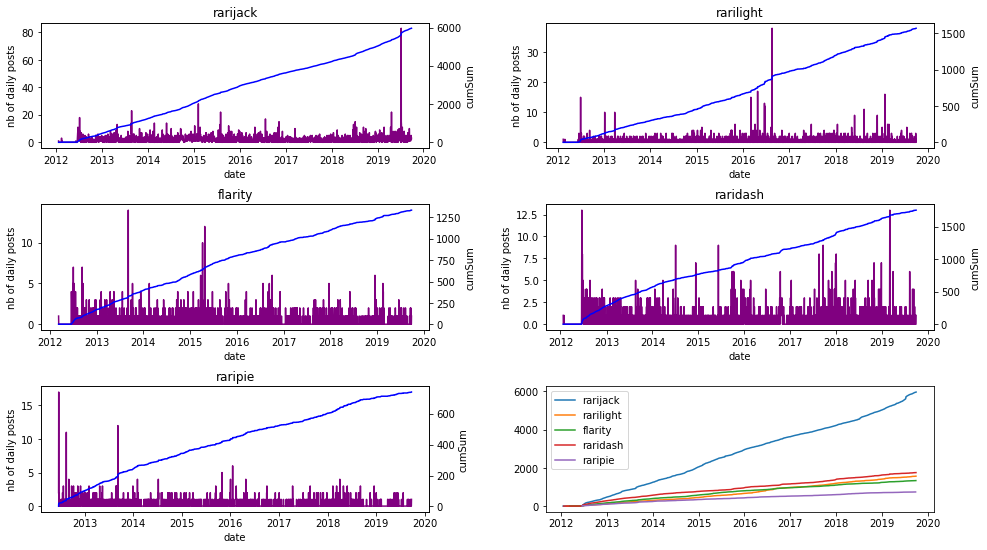

In [8]:
years = mdates.YearLocator() #every year
yearsFmt = mdates.DateFormatter("%Y")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 9))
fig.subplots_adjust(hspace=.45, wspace=.3)

counter = 0
for i in range(3):
    for j in range(2):
        if i * j != 2:
            df = create_dataframe(list(ships.keys())[counter], ships[list(ships.keys())[counter]])
            axes[i, j].set_title(list(ships.keys())[counter])
            axes[i, j].plot(df.index, 
                            df[list(ships.keys())[counter]].values, 
                            color="purple", 
                            label=list(ships.keys())[counter])
            ax2 = axes[i, j].twinx()
            ax2.plot(df.index, 
                     df["cumSum"].values, 
                     color="blue")
            ax2.set_ylabel("cumSum")
            axes[i, j].set_xlabel("date")
            axes[i, j].set_ylabel("nb of daily posts")
            axes[i, j].xaxis.set_major_locator(years)
            axes[i, j].xaxis.set_major_formatter(yearsFmt)
            axes[2, 1].plot(df.index, df["cumSum"].values,
                            label=list(ships.keys())[counter])
        counter += 1

axes[2, 1].xaxis.set_major_locator(years)
axes[2, 1].xaxis.set_major_formatter(yearsFmt)
axes[2, 1].legend()
plt.savefig('foo.png')

# SEPARATING SFW FROM NSFW PICTURES

## Downloading pictures

We need to download a set of pictures which can be used to fit a machine learning model.

In [9]:
def download(tags, nb_of_requests):
    """
    Downloads pictures based on a list of tag.
    ---
    :param <tags>: list ; list of tags to sort and download pictures
    :param <nb_of_requests>: int ; number of download requests to perform
    """
    for tag in tags:
        obj = derpi_get.derpibooru_search()
        obj.change_search(tags = tag, at_least_one = True)
        id_list = obj.retrieve_ids()
        obj.request_imgs(tag, id_list, nb_of_requests)

In [10]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "+suggestive", "+questionable", "-comic", "-meme", "-text"]]

In [ ]:
download(tags, 6000)

## Cleaning extracted pictures

The retrieved pictures are all sized differently and some are unusable. We need to resize them and clean the folders from the unreadable data.

In [7]:
def clean_pictures(targets):
    """
    Cleans the pictures that will be used for training and validation.
    ---
    :param <targets>: list ; list of folders to clean
    """
    for folder in target_folders:
        img_content = os.listdir(folder)
        to_delete = []
        for img in img_content:
            if ((img[-4:] == "jpeg") or 
                (img[-3:] == "jpg") or 
                (img[-3:] == "png")):
                try:
                    image = Image.open(folder + "/" + img)
                    image = image.resize((224, 224))
                    image.save(folder + "/" + img)
                except Exception as e:
                    print(e)
                    os.remove(folder + "/" + img)

The downloaded pictures have been <b>manually</b> copied in "copy" folders to avoid overwriting them.

In [8]:
target_folders = ["./data/+safe-comic-meme-text", 
                  "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
clean_pictures(target_folders)

cannot identify image file './data/+safe-comic-meme-text/48862.jpg'
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


## Running Machine Learning

### Creating samples

Based on all the extracted pictures--and to make the process run in a timely manner on my Surface Pro 2--we are sampling the extracted data:

- 5000 safe and unsafe pictures for training
- 500 safe and unsafe pictures for testing/validation

In [11]:
def create_sample(folders, model_description):
    """
    Samples existing pictures.
    ---
    :param <folders>: list ; list of folders to sample
    :param <model_description>: list ; list of folders where to store samples 
                                 + nb of pictures to extract
    """
    counter = 0
    for model in model_description:
        target_folder = model[0]
        try:
            shutil.rmtree(target_folder)
        except Exception as e: 
            print(e)
        os.makedirs(target_folder)
        
        selection = []
        
        for folder in folders:
            counter = 0
            stored_imgs = os.listdir(folder)
            
            while counter <= model[1]:
                choice = random.choice(stored_imgs)
                if choice not in selection:
                    selection.append(choice)
                    shutil.copy(folder + "/" + choice, target_folder)
                    os.rename(target_folder + "/" + choice,
                             target_folder + "/" + folder[7:].split("-")[0]
                             + "-" + choice)
                    counter += 1

In [12]:
folders = ["./data/+safe-comic-meme-text", 
           "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
model_description = [("./data/train/Training", 5000),
                     ("./data/train/Test", 500)]

create_sample(folders, model_description)

[WinError 3] The system cannot find the path specified: './data/train/Training'
[WinError 3] The system cannot find the path specified: './data/train/Test'


The code below is a rewrite of the following github: [here](https://github.com/CShorten/KaggleDogBreedChallenge/blob/master/DogBreed_BinaryClassification.ipynb?source=post_page---------------------------).
Thanks to CShorten!

In [13]:
def label_img(name):
    """
    Returns whether an image is safe or unsafe based on its name.
    ---
    :param <name>: string ; path/name of a picture
    """
    word_label = name.split('-')[0]
    if word_label.startswith("+safe"): return np.array([1, 0])
    else: return np.array([0, 1])

def load_data(folder):
    """
    Loads the safe/unsafe value of each picture stored in a specific folder.
    ---
    :param <filder>: string ; path of a folder
    """
    test_data = []
    for img in os.listdir(folder):
        label = label_img(img)
        path = os.path.join(folder, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((224, 224), Image.ANTIALIAS)
        test_data.append([np.array(img), label])
    shuffle(test_data)
    return test_data

In [14]:
model_description = [("./data/train/Training", 5000),
                     ("./data/train/Test", 500)]
DIR_TRAINING = model_description[0][0]
DIR_TESTING = model_description[1][0]

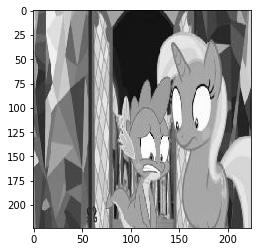

In [15]:
train_data = load_data(DIR_TRAINING)
plt.imshow(train_data[1][0], cmap = 'gist_gray')

trainImages = np.array([i[0] for i in train_data]).reshape(-1, 224, 224, 1)
trainLabels = np.array([i[1] for i in train_data])

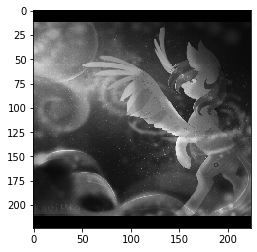

In [16]:
test_data = load_data(DIR_TESTING)    
plt.imshow(test_data[1][0], cmap = 'gist_gray')

testImages = np.array([i[0] for i in test_data]).reshape(-1, 224, 224, 1)
testLabels = np.array([i[1] for i in test_data])

### Machine Learning Modeling

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(GaussianNoise(0.1))
model.add(LeakyReLU(alpha=0.01))

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

In [26]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(), 
              metrics = ['accuracy'])

In [27]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
10002/10002 [==============================] - 1337s 134ms/step - loss: 2.2588 - acc: 0.5390
Epoch 2/20
10002/10002 [==============================] - 1278s 128ms/step - loss: 1.1351 - acc: 0.5623
Epoch 3/20
10002/10002 [==============================] - 1270s 127ms/step - loss: 1.0086 - acc: 0.5511
Epoch 4/20
10002/10002 [==============================] - 1262s 126ms/step - loss: 0.9598 - acc: 0.5462
Epoch 5/20
10002/10002 [==============================] - 1252s 125ms/step - loss: 0.8047 - acc: 0.5325
Epoch 6/20
10002/10002 [==============================] - 1261s 126ms/step - loss: 0.7668 - acc: 0.5241
Epoch 7/20
10002/10002 [==============================] - 1268s 127ms/step - loss: 0.7280 - acc: 0.5169
Epoch 8/20
10002/10002 [==============================] - 1260s 126ms/step - loss: 0.7121 - acc: 0.5035
Epoch 9/20
10002/10002 [==============================] - 1264s 126ms/step - loss: 0.7119 - acc: 0.5166
Epoch 10/20
10002/10002 [==============================] - 1263s

In [28]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

76.74650696223367


As at September 22th, the prediction power of the model over the test sample is of 96.5%.

In [29]:
model.save('NSFWdetector_20e32bs_v1.h5')

### Training with a different optimizer

Switching from RMSProp to Adam as an optimizer on a sample of the same population.

In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics = ['accuracy'])

W0930 19:07:15.313531  4384 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0930 19:07:15.401480  4384 deprecation.py:323] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
10002/10002 [==============================] - 1287s 129ms/step - loss: 2.1660 - acc: 0.5358
Epoch 2/20
10002/10002 [==============================] - 1220s 122ms/step - loss: 0.8580 - acc: 0.5370
Epoch 3/20
10002/10002 [==============================] - 1490s 149ms/step - loss: 0.7125 - acc: 0.5355
Epoch 4/20
10002/10002 [==============================] - 1276s 128ms/step - loss: 0.6902 - acc: 0.5639
Epoch 5/20
10002/10002 [==============================] - 1269s 127ms/step - loss: 0.6714 - acc: 0.5951
Epoch 6/20
10002/10002 [==============================] - 1272s 127ms/step - loss: 0.6517 - acc: 0.6201
Epoch 7/20
10002/10002 [==============================] - 1343s 134ms/step - loss: 0.6161 - acc: 0.6552
Epoch 8/20
10002/10002 [==============================] - 1470s 147ms/step - loss: 0.5718 - acc: 0.6929
Epoch 9/20
10002/10002 [==============================] - 1462s 146ms/step - loss: 0.5253 - acc: 0.7290
Epoch 10/20
10002/10002 [==============================] - 1599s

In [20]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

92.71457085828342


In [21]:
model.save('NSFWdetector_20e32bs_v2.h5')